# Vision Transformer for im2latex

The feature extractor and encoder will be fine-tuned off Google's ViT Model, located at `./model/vit-base-patch16-224-in21k`, and the decoder and tokenizer will use the pretrained items from `./decoder.ipynb`

The model will be trained on latex data, which is slightly augmented to increase generality (in consideration for future tasks).

## Build Dataset

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from datasets import load_from_disk
from PIL import Image
import os
import matplotlib.pyplot as plt

from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
from transformers import ViTHybridImageProcessor, ViTHybridConfig

/home/leocftian/programs/image-2-latex/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = "./data/im2latex-250k/"
ROBERTA_PATH = "./model/roberta"
VIT_PATH = "./model/vit-hybrid-base-bit-384"
TOKENIZER_PATH = "./model/tokenizer"
MODEL_PATH = "./model/ocr"

# Load dataset and check format
im2latex_dataset = load_from_disk(DATA_DIR)

In [3]:
# Reload tokenizer with necessary processors
tokenizer = ByteLevelBPETokenizer(
    os.path.join(TOKENIZER_PATH, "vocab.json"),
    os.path.join(TOKENIZER_PATH, "merges.txt"),
)
tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)
tokenizer.enable_padding(length=512)

# Load feature extractor
image_processor = ViTHybridImageProcessor.from_pretrained(VIT_PATH)
image_processor.do_center_crop = False
image_processor.size = {
    "height": 384,
    "width": 384
}

In [4]:
# Randomly pads image
class RandomPad(object):
    """
    pad_size: specify min and max padding
    """
    def __init__(self, pad_size):
        assert isinstance(pad_size, tuple)
        assert pad_size[0] < pad_size[1]
        self.pad_size = pad_size

    def __call__(self, image):
        padding = torch.randint(self.pad_size[0], self.pad_size[1], (4,))
        width, height = image.size 
        new_width = width + padding[0] + padding[1] 
        new_height = height + padding[2] + padding[3]
        
        result = Image.new(image.mode, (new_width, new_height), (255, 255, 255)) 
        result.paste(image, (padding[0], padding[2])) 

        return result

In [5]:
transform = transforms.Compose([
    transforms.RandomApply([
        RandomPad((0, 50)),
        transforms.RandomRotation(10, expand=True, fill=255),
        transforms.RandomPerspective(0.1, fill=255),
        transforms.ElasticTransform(alpha=2.5, fill=255),
        transforms.ColorJitter((0.5, 1.1), 0.1, 0.1, 0.5),
        transforms.RandomAdjustSharpness(0.5, 1),
    ], 0.5),
    transforms.RandomInvert(0.5)
])

In [6]:
# Create the Im2latexData torch dataset class
      
class Im2latexData(Dataset):
    def __init__(self, latex_data, tokenizer, feature_extractor, transform=None):
        self.examples = latex_data
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.transform = transform
        
    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        # Augment image if possible
        image = self.examples[idx]["image"]
        if (self.transform and image.size[0] >= 20 and image.size[1] >= 20):
            image = self.transform(self.examples[idx]["image"].convert("RGB"))
        
        # Encode values
        formula = self.tokenizer.encode(self.examples[idx]["formula"])
        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values.squeeze()
        labels = torch.tensor(formula.ids)
        attention_mask = torch.tensor(formula.attention_mask)
        
        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "attention_mask": attention_mask
        }

# Create Im2latex torch Datasets
train_dataset = Im2latexData(im2latex_dataset["train"], tokenizer=tokenizer, feature_extractor=image_processor)
val_dataset = Im2latexData(im2latex_dataset["val"], tokenizer=tokenizer, feature_extractor=image_processor)
test_dataset = Im2latexData(im2latex_dataset["test"], tokenizer=tokenizer, feature_extractor=image_processor)

## Initialize Vision Transformer

In [7]:
from transformers import RobertaTokenizerFast, VisionEncoderDecoderModel
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, default_data_collator

In [8]:
# Define tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained(TOKENIZER_PATH)
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(VIT_PATH, ROBERTA_PATH)

Some weights of ViTHybridModel were not initialized from the model checkpoint at ./model/vit-hybrid-base-bit-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at ./model/roberta and are newly initialized: ['roberta.encoder.layer.0.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.0.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.0.crossattention.output.dense.bias', 'roberta.encoder.layer.0.crossattention.output.dense.weight', 'roberta.encoder.layer.0.crossattention.self.key.bias', 'roberta.encoder.layer.0.crossattention.self.key.weight', 'roberta.encoder.layer.0.crossattention.self.query.bias', 'roberta.encoder.layer.0.crossattention.self.query.weight', 'roberta.encoder.layer.0.crossattention.self.value.bias', 'roberta.encoder.layer.0.

In [9]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
model.config.decoder.max_length = 512

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id

In [10]:
TRAIN_EPOCHS = 5
EVAL_STEPS = 16384
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.01
TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

training_args = Seq2SeqTrainingArguments(
    output_dir=MODEL_PATH,
    evaluation_strategy = 'epoch',
    overwrite_output_dir=True,
    eval_steps=EVAL_STEPS,
    num_train_epochs=TRAIN_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VAL_BATCH_SIZE,
    save_total_limit=1,
) 

trainer = Seq2SeqTrainer(
    tokenizer=image_processor,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)

trainer.train(resume_from_checkpoint=True)

There were missing keys in the checkpoint model loaded: ['decoder.lm_head.decoder.weight', 'decoder.lm_head.decoder.bias'].


Epoch,Training Loss,Validation Loss


Removed shared tensor {'decoder.lm_head.decoder.weight', 'decoder.lm_head.decoder.bias'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


KeyboardInterrupt: 

In [11]:
trainer.save_model(MODEL_PATH)

In [12]:
import random
import time
from PIL import Image, ImageOps, ImageGrab
import numpy as np

In [13]:
model = VisionEncoderDecoderModel.from_pretrained(MODEL_PATH)

tokenizer = ByteLevelBPETokenizer(
    os.path.join(TOKENIZER_PATH, "vocab.json"),
    os.path.join(TOKENIZER_PATH, "merges.txt"),
)
tokenizer.add_special_tokens(["<s>", "</s>", "<pad>", "<mask>", "<unk>"])

image_processor = ViTHybridImageProcessor.from_pretrained(MODEL_PATH)

random.seed(time.time())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted LaTeX: \begin{array} { c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c } } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c } & { c c c } & { c c c } & { c } & { c } & { c } } & { c } & { c } & { c } & { c } & { c } & { c } & { c } & {

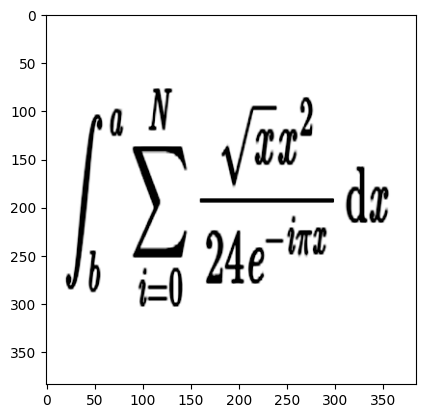

In [14]:
# index = random.randint(0, im2latex_dataset["test"].num_rows - 1)
# image = im2latex_dataset["test"][index]["image"]

image = Image.open("data/samples/Screenshot 2024-02-26 152853.png").convert("RGB")
# image = image.crop(ImageOps.invert(image).getbbox())

# if (image.size[1] > 50):
#     height = 50
#     width = int(image.size[0] * (height / image.size[1]))
#     image = image.resize((width, height))

# image = transform(image)

generated_ids = model.generate(image_processor(image, return_tensors="pt").pixel_values, max_length=512)
generated_text = tokenizer.decode(generated_ids.tolist()[0], skip_special_tokens=True)

image = image_processor(image, return_tensors="pt").pixel_values.numpy().squeeze(axis=0)
image = image.swapaxes(0, 1)
image = image.swapaxes(1, 2)

plt.imshow(image)
print(f"Predicted LaTeX: {generated_text}")